Importing the necessary libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Movie Genre Classification/movies dataset/Genre Classification Dataset/train_data.txt', sep=' ::: ', engine='python', header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Movie Genre Classification/movies dataset/Genre Classification Dataset/test_data_solution.txt', sep=' ::: ', engine='python', header=None, names=['ID', 'TITLE','GENRE', 'DESCRIPTION'])

EDA

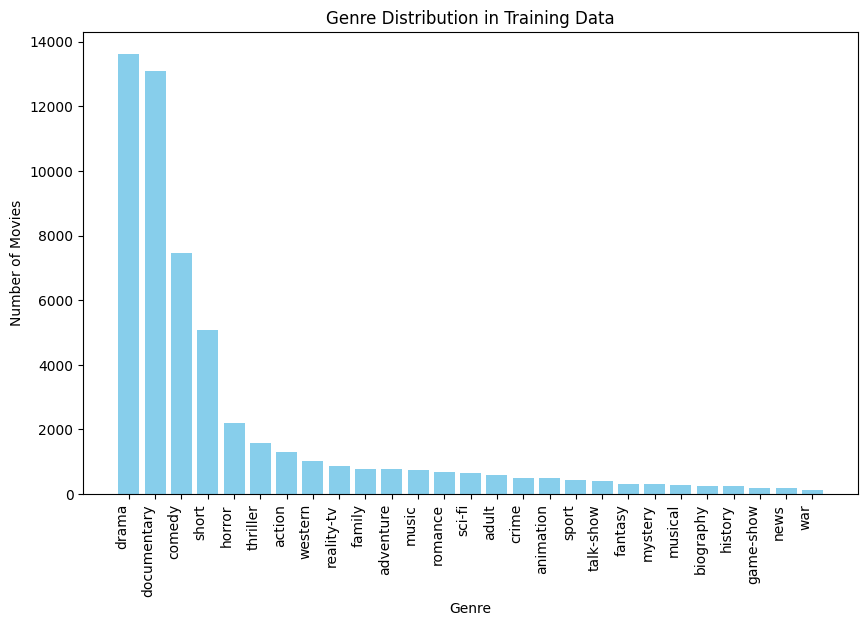

In [5]:
genre_counts = train_data['GENRE'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts, color='skyblue')
plt.title('Genre Distribution in Training Data')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')
plt.show()


In [6]:
train_data['GENRE'].value_counts()

drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: GENRE, dtype: int64

In [7]:
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [8]:
test_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...


In [9]:
train_data.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [10]:
test_data.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [11]:
train_description = train_data['DESCRIPTION']
test_description = test_data['DESCRIPTION']

Cleaning the description

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
def remove_stopwords(sentence):
    sentence = sentence.lower()

    sentence = re.sub(r'@\S+', '', sentence)

    sentence = re.sub(r'http\S+', '', sentence)

    sentence = re.sub(r'pic.\S+', '', sentence)

    sentence = re.sub(r"[^a-zA-Z']", ' ', sentence)

    words = word_tokenize(sentence)

    stopwords_set = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwords_set and len(word) > 2]

    cleaned_sentence = ' '.join(words)

    return cleaned_sentence.strip()

train_sentences = []
for sentence in train_description:
    sentence = remove_stopwords(sentence)
    train_sentences.append(sentence)

print(len(train_sentences))
print(train_sentences[0])
print(train_description[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


54214
listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.


In [13]:
test_sentences = []
for sentence in test_description:
    sentence = remove_stopwords(sentence)
    test_sentences.append(sentence)

In [14]:
train_data['cleaned_description'] = train_sentences
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,cleaned_description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,listening conversation doctor parents year old...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,bus empties students field trip museum natural...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,help unemployed father make ends meet edith tw...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,film title refers recovered bodies ground zero...


In [15]:
test_data['cleaned_description'] = test_sentences
test_data.head()

,ID,TITLE,GENRE,DESCRIPTION,cleaned_description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his...",father died n't spoken brother years serious c...
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...,known internationally martial arts superstar b...


In [16]:
train_data['cleaned_description_length']=train_data['cleaned_description'].apply(len)
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,cleaned_description,cleaned_description_length
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,listening conversation doctor parents year old...,383
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,brother sister past incestuous relationship cu...,119
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,bus empties students field trip museum natural...,400
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,help unemployed father make ends meet edith tw...,744
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,film title refers recovered bodies ground zero...,401


Visualizing the sentence lengths

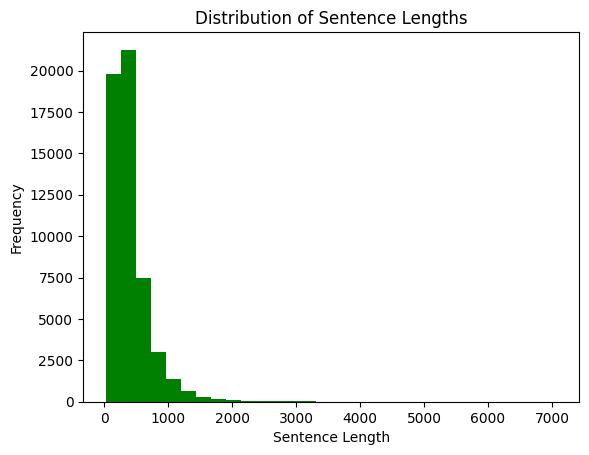

In [17]:
train_sentences_frequency = []
for length in train_data['cleaned_description_length']:
    train_sentences_frequency.append(length)
plt.hist(train_sentences_frequency, bins=30, color='green')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

In [19]:
(train_data['cleaned_description_length']>2000).value_counts()


False    54019
True       195
Name: cleaned_description_length, dtype: int64

Removing the outliers

In [20]:
filter = train_data['cleaned_description_length'] > 2000
filter.head()
train_data.drop(train_data[filter].index,axis=0,inplace=True)
len(train_data)

54019

Initializing the global needed variables

In [91]:
MAX_LEN = 150
NUM_WORDS = 10000
EMBEDDING_DIM = 16


Initializing the tokenizer

In [92]:
tokenizer = Tokenizer(num_words=NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['cleaned_description'].values)

One hot encoding the genre labels

In [93]:
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_description'].values)
X = pad_sequences(train_sequences, maxlen=MAX_LEN, padding = 'post')
y = pd.get_dummies(train_data['GENRE']).values
print(X)
print(y)
print(X.shape)

[[4920 1826  363 ...    0    0    0]
 [  98  145   81 ...    0    0    0]
 [1477    1  271 ...    0    0    0]
 ...
 [   1    1  606 ...    0    0    0]
 [2353    1   53 ...    0    0    0]
 [2520   22 1064 ...    0    0    0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(54019, 150)


In [94]:
test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_description'].values)
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding = 'post')
y_test = pd.get_dummies(test_data['GENRE']).values

Defining the Model

In [104]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(27, activation='softmax')
    ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


Setting up callbacks

In [106]:
# Define the ModelCheckpoint callback
checkpoint_filepath = 'best_model.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_best_only=True,
                                   monitor='val_accuracy',  # Choose the metric to monitor
                                   mode='max',  # Choose 'max' for accuracy, 'min' for loss, etc.
                                   verbose=1)

Fitting the model

In [107]:
my_callbacks  = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
history = model.fit(X, y, epochs=10, batch_size=64,validation_data=(X_test, y_test), callbacks=[my_callbacks, model_checkpoint])

Epoch 1/10
845/845 [==============================] - ETA: 0s - loss: 1.8279 - accuracy: 0.4650
Epoch 1: val_accuracy improved from -inf to 0.54887, saving model to best_model.h5
845/845 [==============================] - 43s 49ms/step - loss: 1.8279 - accuracy: 0.4650 - val_loss: 1.5373 - val_accuracy: 0.5489
Epoch 2/10
845/845 [==============================] - ETA: 0s - loss: 1.3783 - accuracy: 0.5949
Epoch 2: val_accuracy improved from 0.54887 to 0.55801, saving model to best_model.h5
845/845 [==============================] - 14s 16ms/step - loss: 1.3783 - accuracy: 0.5949 - val_loss: 1.5015 - val_accuracy: 0.5580
Epoch 3/10
845/845 [==============================] - ETA: 0s - loss: 1.1740 - accuracy: 0.6439
Epoch 3: val_accuracy improved from 0.55801 to 0.56483, saving model to best_model.h5
845/845 [==============================] - 8s 9ms/step - loss: 1.1740 - accuracy: 0.6439 - val_loss: 1.5210 - val_accuracy: 0.5648
Epoch 4/10
834/845 [============================>.] - ETA: 0

In [108]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
best_model.summary()



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 150, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
 7 (GlobalAveragePooling1D)                                      
                                                                 
 dense_42 (Dense)            (None, 128)               2176      
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 27)                3483      
                                                                 
Total params: 165659 (647.11 KB)
Trainable params: 165659 (647.11 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

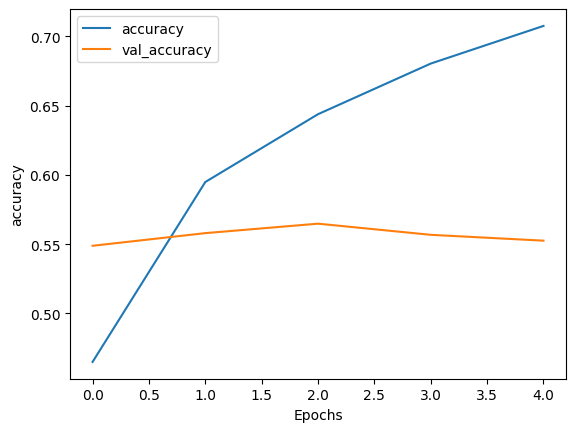

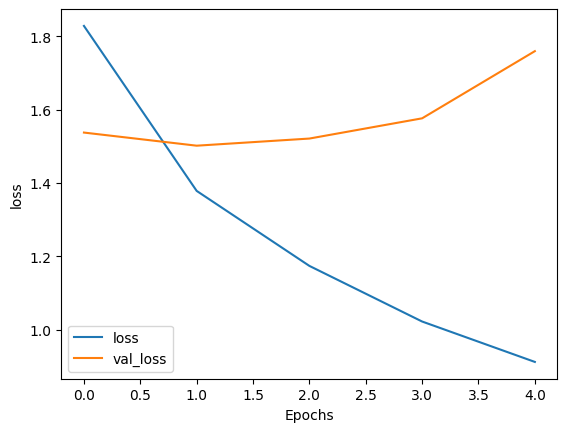

In [109]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")